 # Multi-Stage Failure Labeling and Risk Assessment Pipeline



 This notebook orchestrates the process:

 1. **Load & Prepare Data:** Reads CMAPSS data, handles multiple files, creates unique IDs.

 2. **Clustering & Staging:** Scales sensors, applies KMeans/GMM, interprets clusters as degradation stages based on time.

 3. **Classification:** Trains models (XGBoost, LogReg, SVC) to predict the derived degradation stage.

 4. **Regression:** Calculates Time-to-Next-Stage (TTNS) and trains models (XGBoost, HistGB, NuSVR) to predict it.

 5. **Risk Assessment:** Combines stage prediction probability and TTNS prediction into a normalized risk score and generates maintenance alerts.

 6. **Visualization:** Shows results at each step (distributions, PCA, trends, confusion matrices, TTNS plots, risk plots).

 ## Setup and Configuration

 Change which Dataset or Datasets you want to use in the config.py file

In [1]:
import pandas as pd
import numpy as np
import warnings
import time

# Import custom modules
from config import * # Load all constants from config.py
from data_loader import load_and_preprocess_raw_data
from plotting import (plot_cluster_distribution, plot_pca_clusters,
                    plot_sensor_trends_by_stage,
                    plot_risk_trends_sample_engines, plot_and_save_engine_risk_trends)
from clustering import identify_and_scale_sensors, run_clustering_phase
from classification import train_and_evaluate_classifiers # Rolling features handled internally
from regression import calculate_ttns_for_dataset, train_and_evaluate_regressors
from risk_assessment import calculate_and_evaluate_risk


# Configure warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# Display Configuration
print(f"Using Dataset Path: {DATASET_PATH}")
print(f"Using Dataset IDs: {DATASET_IDS}")
print(f"Combined Dataset Name: {COMBINED_DATASET_NAME}")
print(f"Number of Degradation Stages to derive: {N_CLUSTERS}")
print(f"Random State: {RANDOM_STATE}")
print(f"Risk Threshold for Alerts: {RISK_THRESHOLD}")
print(f"Rolling Feature Window Size: {ROLLING_WINDOW_SIZE}")


Using Dataset Path: CMaps/
Using Dataset IDs: ['FD001', 'FD003']
Combined Dataset Name: FD001+FD003
Number of Degradation Stages to derive: 5
Random State: 42
Risk Threshold for Alerts: 0.7
Rolling Feature Window Size: 50


 ## Phase 0: Data Loading and Initial Preparation

In [2]:
start_time_total = time.time()

# Load data using the dedicated function
df_train_raw = load_and_preprocess_raw_data(DATASET_PATH, DATASET_IDS)

if df_train_raw is None:
    print("Stopping execution due to data loading errors.")
else:
    print("\nRaw data loaded successfully.")
    # Define column sets based on the final loaded dataframe
    all_cols = df_train_raw.columns
    sensor_cols = [col for col in all_cols if col.startswith('sensor_')]
    op_setting_cols = [col for col in all_cols if col.startswith('operational_setting_')]
    print(f"Identified {len(sensor_cols)} sensor columns.")
    print(f"Identified {len(op_setting_cols)} operational setting columns.")


Loading Data for Datasets: ['FD001', 'FD003']
Attempting to load: CMaps/train_FD001.txt
Successfully loaded train_FD001.txt. Shape: (20631, 27)
Attempting to load: CMaps/train_FD003.txt
Successfully loaded train_FD003.txt. Shape: (24720, 27)

Combined raw data shape: (45351, 27)
Sample of combined data (note unique 'unit_number'):
  unit_number  time_in_cycles  operational_setting_1  operational_setting_2  \
0     FD001_1               1                -0.0007                -0.0004   
1     FD001_1               2                 0.0019                -0.0003   
2     FD001_1               3                -0.0043                 0.0003   
3     FD001_1               4                 0.0007                 0.0000   
4     FD001_1               5                -0.0019                -0.0002   

   operational_setting_3  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
0                  100.0    518.67    641.82   1589.70   1400.60     14.62   
1                  100.0    518.67 

 ## Phase 1: Clustering for Multi-Stage Failure Labeling


Sensor Preprocessing
Checking for low-variance sensors...
Dropping Sensors columns with std dev < 0.01: ['sensor_1', 'sensor_18', 'sensor_19', 'sensor_16', 'sensor_5', 'sensor_10']

Scaling active sensor data using StandardScaler...
Active sensor data scaled.
  unit_number  time_in_cycles dataset_id  operational_setting_1  \
0     FD001_1               1      FD001                -0.0007   
1     FD001_1               2      FD001                 0.0019   
2     FD001_1               3      FD001                -0.0043   
3     FD001_1               4      FD001                 0.0007   
4     FD001_1               5      FD001                -0.0019   

   operational_setting_2  operational_setting_3  sensor_2  sensor_3  sensor_4  \
0                -0.0004                  100.0 -1.409364  0.076860 -0.609157   
1                -0.0003                  100.0 -0.780302  0.396965 -0.346968   
2                 0.0003                  100.0 -0.399052 -0.181338 -0.237551   
3           

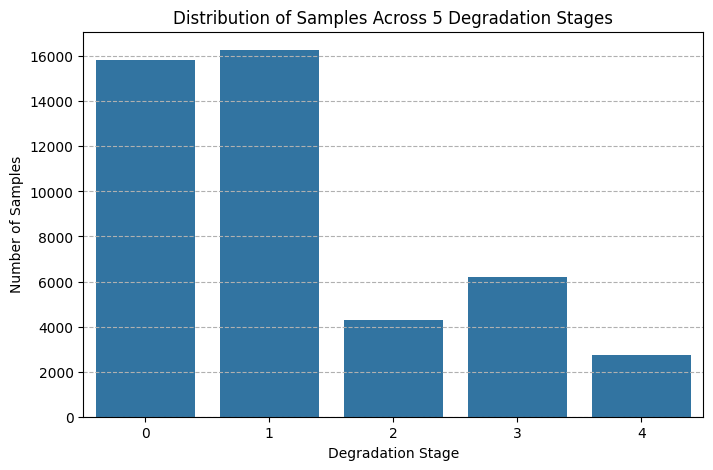

Plotting distribution for GMM derived stages ('gmm_stage')...


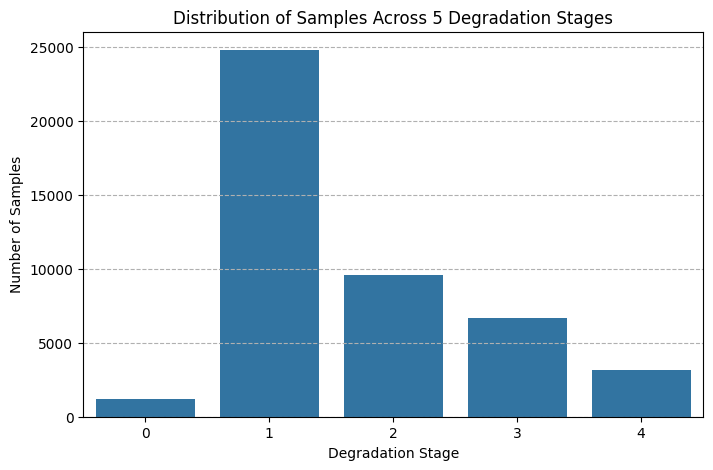


Plotting PCA for KMeans derived stages...


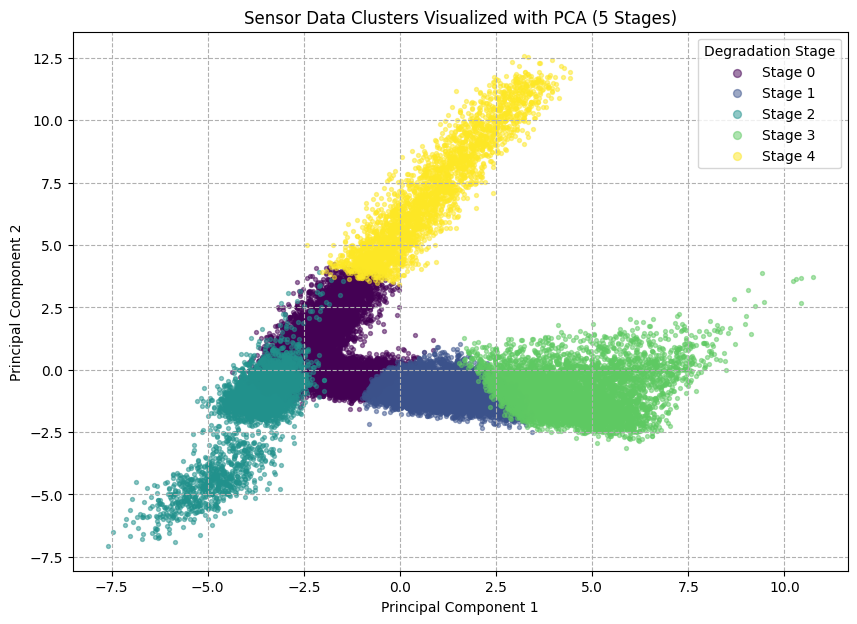

Plotting PCA for GMM derived stages...


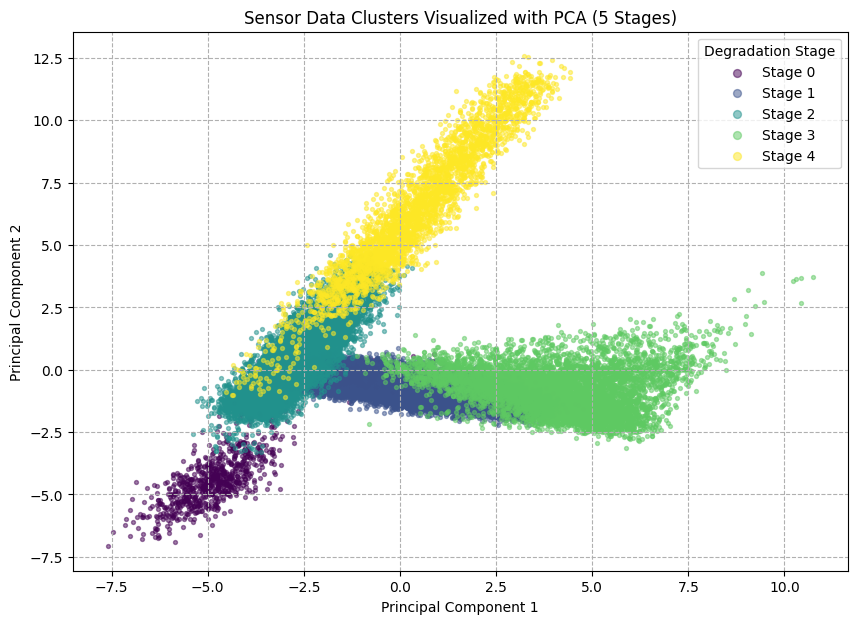


Visualizing sensor trends colored by derived degradation stage (KMeans)...

Plotting sensor trends for sample engines: [np.str_('FD001_11'), np.str_('FD001_50'), np.str_('FD003_21'), np.str_('FD003_20')]


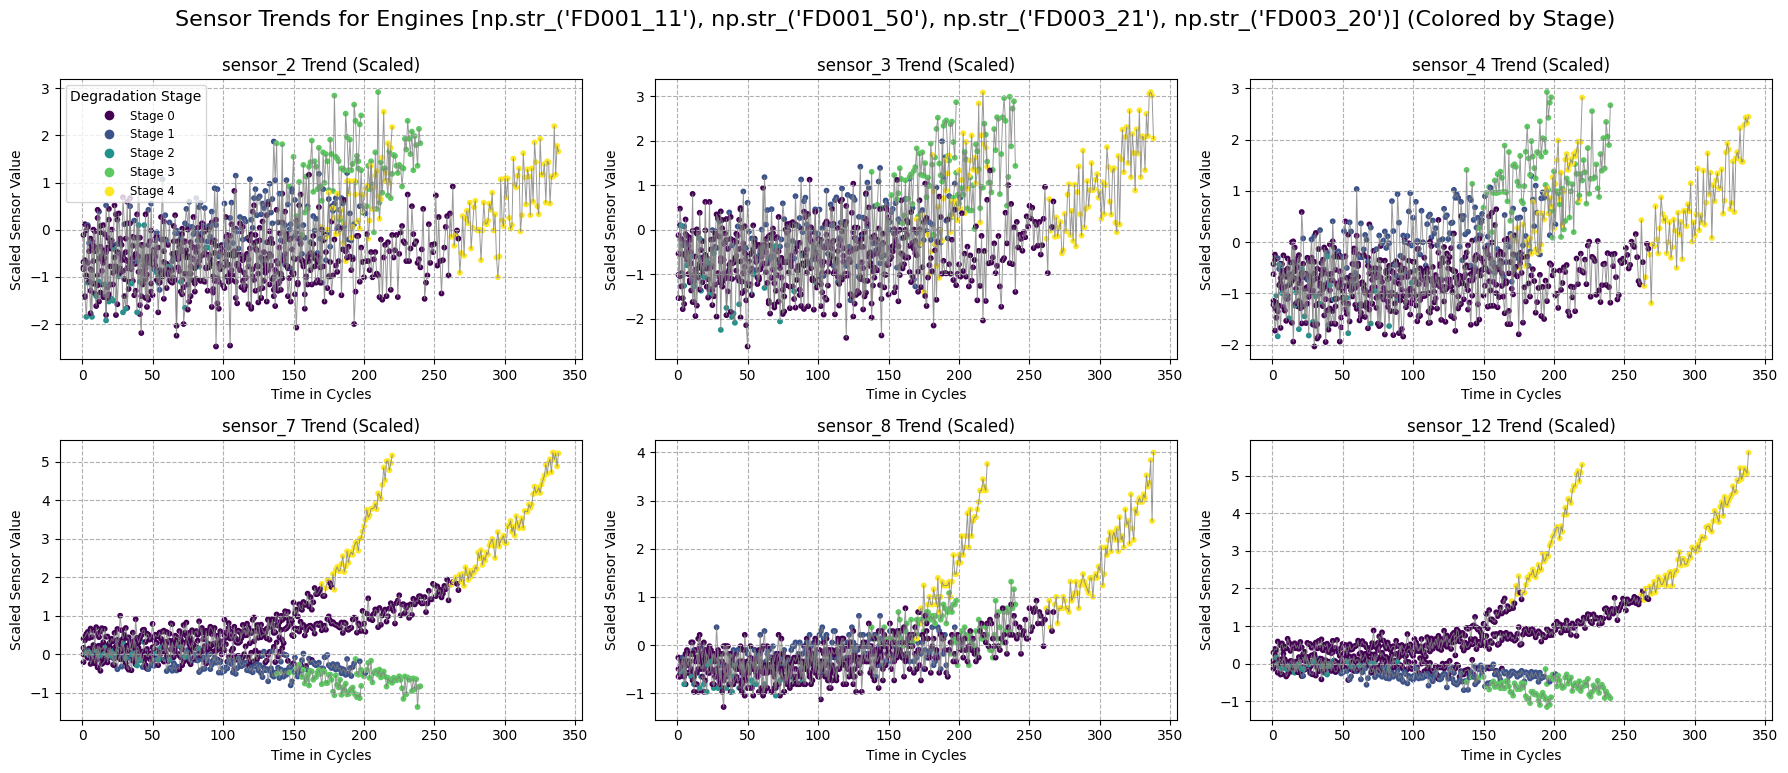


Visualizing sensor trends colored by derived degradation stage (GMM)...

Plotting sensor trends for sample engines: [np.str_('FD001_11'), np.str_('FD001_50'), np.str_('FD003_21'), np.str_('FD003_20')]


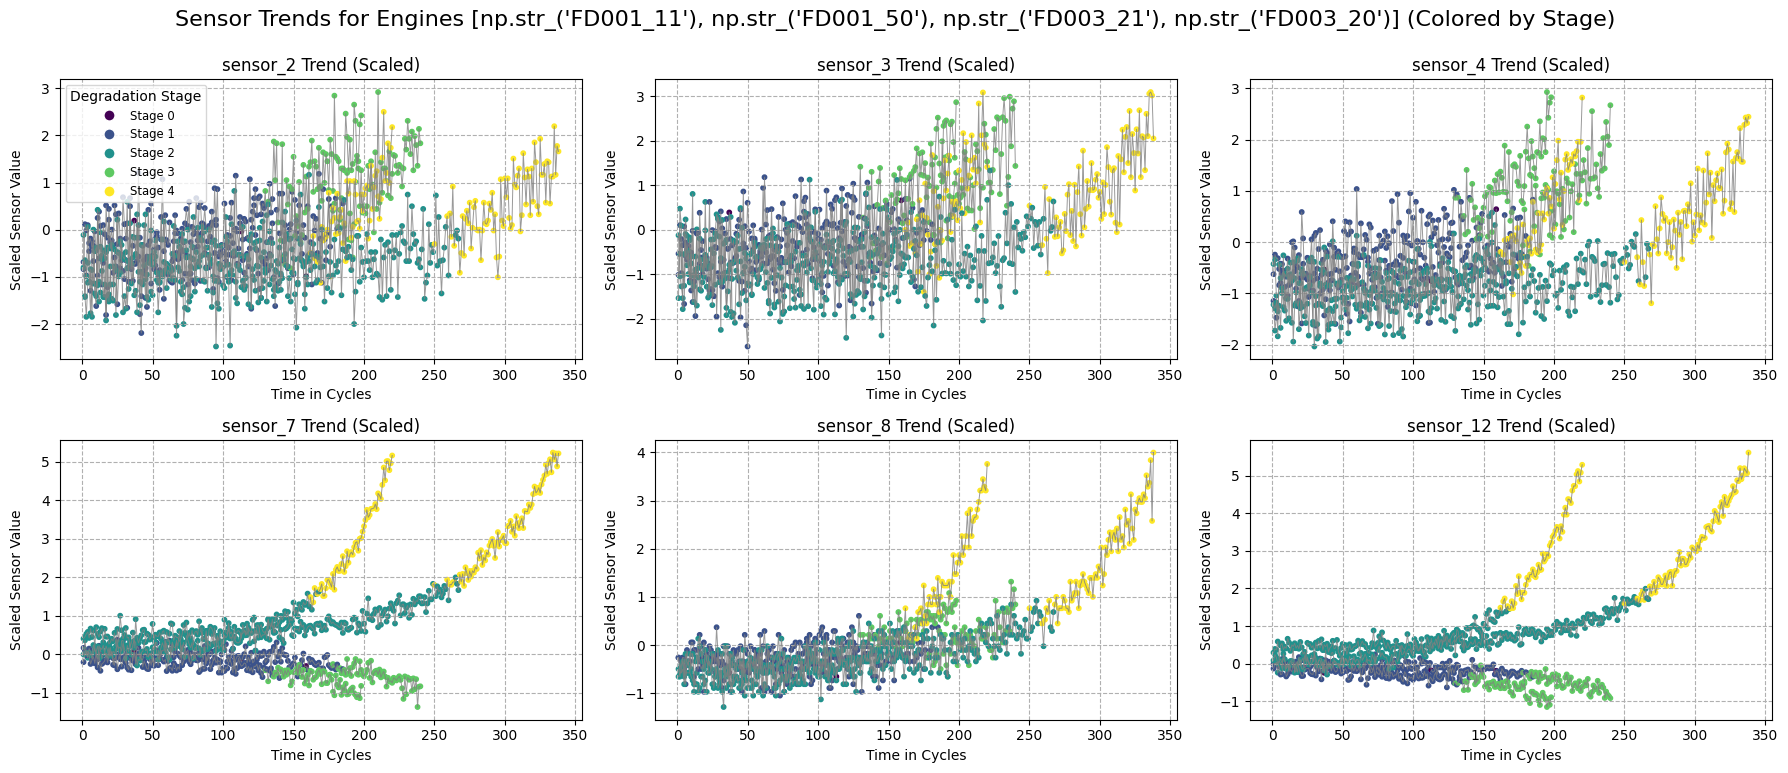

In [3]:
if df_train_raw is not None:
    # Step 1a: Identify low variance sensors and scale active ones
    df_train_processed, scaler_sensors, active_sensor_cols = identify_and_scale_sensors(
        df_train_raw, sensor_cols # Pass the original list of sensor columns
    )
    print(f"\nUsing {len(active_sensor_cols)} active sensor columns for clustering.")

    # Step 1b: Run KMeans and GMM clustering, interpret stages, run PCA
    (df_train_clustered, kmeans_model, gmm_model,
     kmeans_stage_map, gmm_stage_map,
     pca, X_pca) = run_clustering_phase(
        df_train_processed, active_sensor_cols, N_CLUSTERS, RANDOM_STATE
     )

    #Visualize Clustering Results
    print("\nVisualizing Clustering Results")

    # 1. Distribution plots (KMeans derived stage is primary: 'degradation_stage')
    print("Plotting distribution for KMeans derived stages ('degradation_stage')...")
    plot_cluster_distribution(df_train_clustered, 'degradation_stage', N_CLUSTERS)
    print("Plotting distribution for GMM derived stages ('gmm_stage')...")
    plot_cluster_distribution(df_train_clustered, 'gmm_stage', N_CLUSTERS)


    # 2. PCA plots
    print("\nPlotting PCA for KMeans derived stages...")
    plot_pca_clusters(X_pca, df_train_clustered['degradation_stage'], N_CLUSTERS)
    print("Plotting PCA for GMM derived stages...")
    plot_pca_clusters(X_pca, df_train_clustered['gmm_stage'], N_CLUSTERS)


    # 3. Sensor Trends Visualization for sample engines
    print("\nVisualizing sensor trends colored by derived degradation stage (KMeans)...")
    # Select sensors to plot (use defaults, filter by active)
    sensors_to_plot_active = [s for s in DEFAULT_SENSORS_TO_PLOT if s in active_sensor_cols]
    if not sensors_to_plot_active: # Fallback if default sensors were dropped
        sensors_to_plot_active = active_sensor_cols[:min(len(active_sensor_cols), 6)]

    # Select sample engines intelligently across datasets if possible
    unique_engine_ids = df_train_clustered['unit_number'].unique()
    sample_engines_list = []
    if len(DATASET_IDS) > 1:
         for d_id in DATASET_IDS:
             engines_from_dset = [eng for eng in unique_engine_ids if eng.startswith(d_id + '_')]
             sample_engines_list.extend(np.random.choice(engines_from_dset, min(len(engines_from_dset), 2), replace=False)) # Pick 2 random from each
         PLOT_SAMPLE_ENGINES = sample_engines_list[:min(len(sample_engines_list), MAX_PLOT_SAMPLE_ENGINES)] # Limit total samples
    else: # Only one dataset loaded
         PLOT_SAMPLE_ENGINES = list(np.random.choice(unique_engine_ids, min(len(unique_engine_ids), MAX_PLOT_SAMPLE_ENGINES), replace=False))

    if not PLOT_SAMPLE_ENGINES: # Handle case where no engines are available
         print("Warning: No sample engines could be selected for trend plotting.")
    elif not sensors_to_plot_active:
        print("Warning: No active sensors available to plot trends.")
    else:
        plot_sensor_trends_by_stage(
            df_train_clustered, sensors_to_plot_active, 'degradation_stage', PLOT_SAMPLE_ENGINES, N_CLUSTERS
        )
        print("\nVisualizing sensor trends colored by derived degradation stage (GMM)...")
        plot_sensor_trends_by_stage(
           df_train_clustered, sensors_to_plot_active, 'gmm_stage', PLOT_SAMPLE_ENGINES, N_CLUSTERS
        )


 ## Phase 2: Classification Model (Predicting Degradation Stage)

 Uses the primary derived stage ('degradation_stage' from KMeans) as the target. Includes rolling features.


Phase 2: Classification Model (Predicting Degradation Stage)

Adding rolling window features (window size: 50)...
Added 30 rolling window features.

Step 1: Define Features (X) and Target (y)
Using target column: 'degradation_stage'
Features (48): ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7']...['sensor_21_roll_mean_50', 'sensor_21_roll_std_50']
Target: degradation_stage

Step 2: Split into train and test data and scale
Data split into Train (36280 samples) and Validation (9071 samples)
Scaling 33 numeric features...
Numeric features scaled.

Step 3: Train the classifier models (XGBoost, Logistic Regression, Support Vector Classifier)

Training Classifier 1: XGBoost...
XGBoost training completed in 11.34 seconds.

Training Classifier 2: Logistic Regression...
Logistic Regression training completed in 4.94 seconds.

Training Classifier 3: Support Vector Classifier (SVC)...
SVC training completed in 33.80 seconds.

Step 4: Evaluating Classifiers on Validation Set

Evaluat

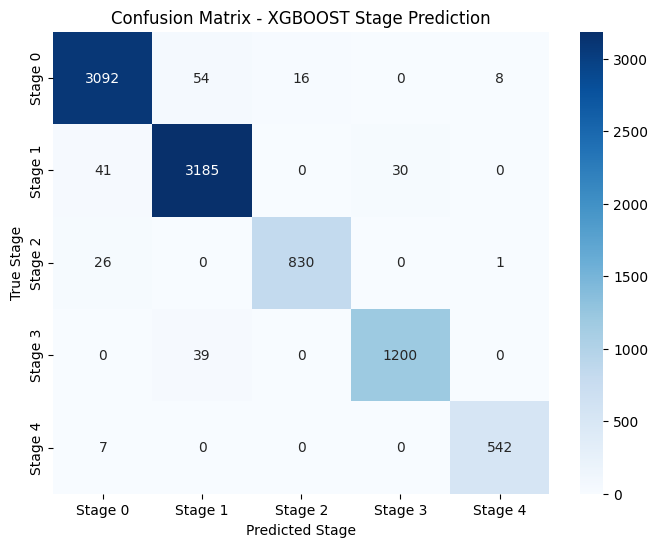


Plotting Feature Importances/Coefficients for XGBOOST...


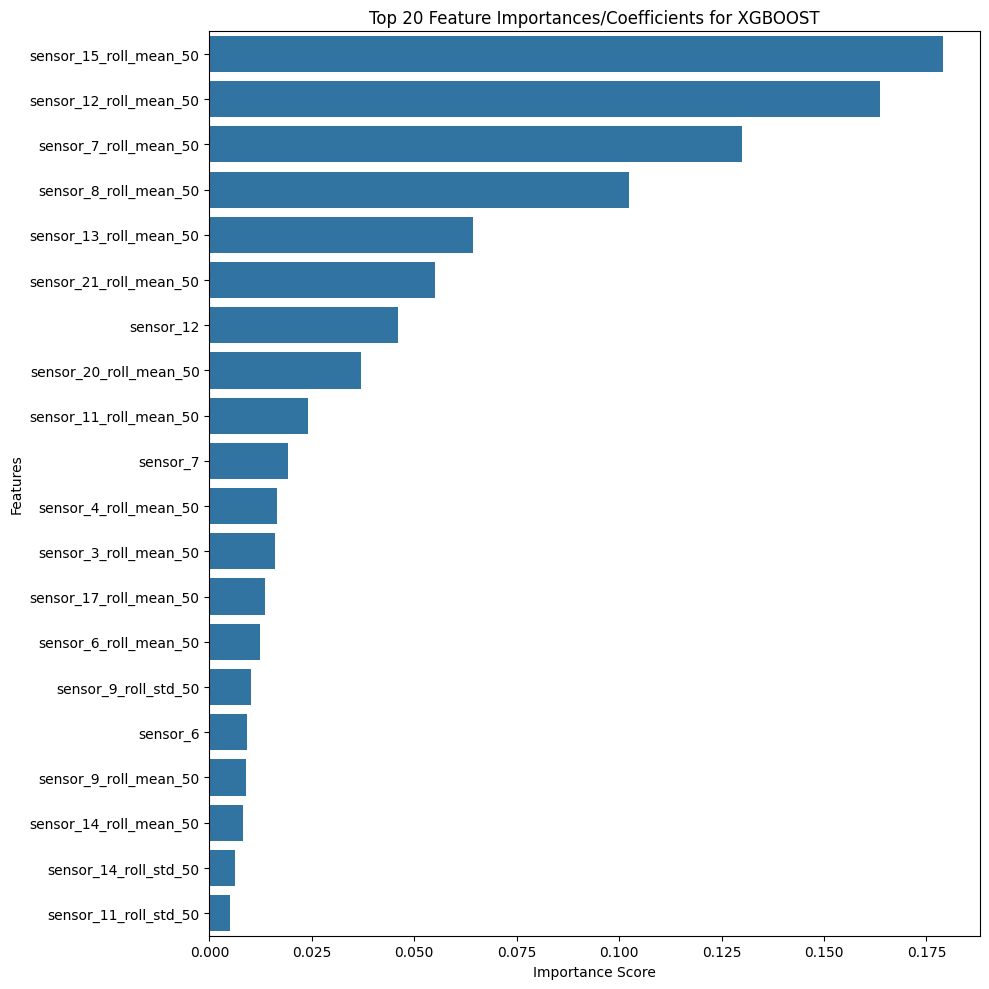


Evaluation for: LOGISTIC_REGRESSION

Classification Report:
              precision    recall  f1-score   support

     Stage 0       0.94      0.91      0.93      3170
     Stage 1       0.93      0.94      0.93      3256
     Stage 2       0.97      0.98      0.98       857
     Stage 3       0.96      0.99      0.98      1239
     Stage 4       0.94      0.99      0.96       549

    accuracy                           0.94      9071
   macro avg       0.95      0.96      0.95      9071
weighted avg       0.94      0.94      0.94      9071

Overall Accuracy: 0.9426


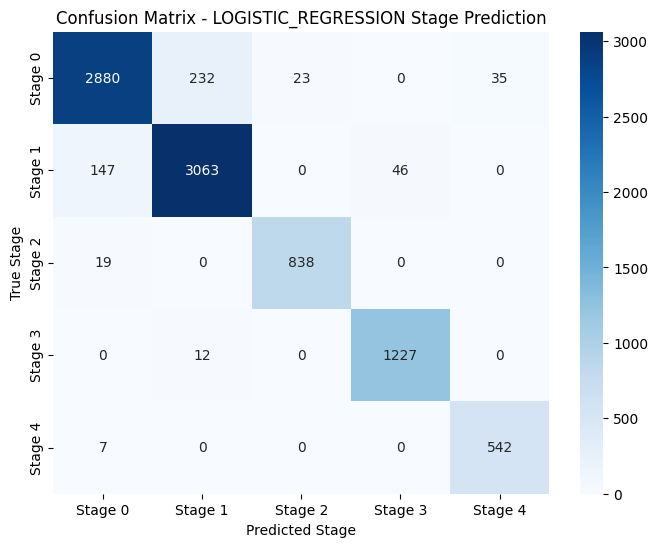


Plotting Feature Importances/Coefficients for LOGISTIC_REGRESSION...


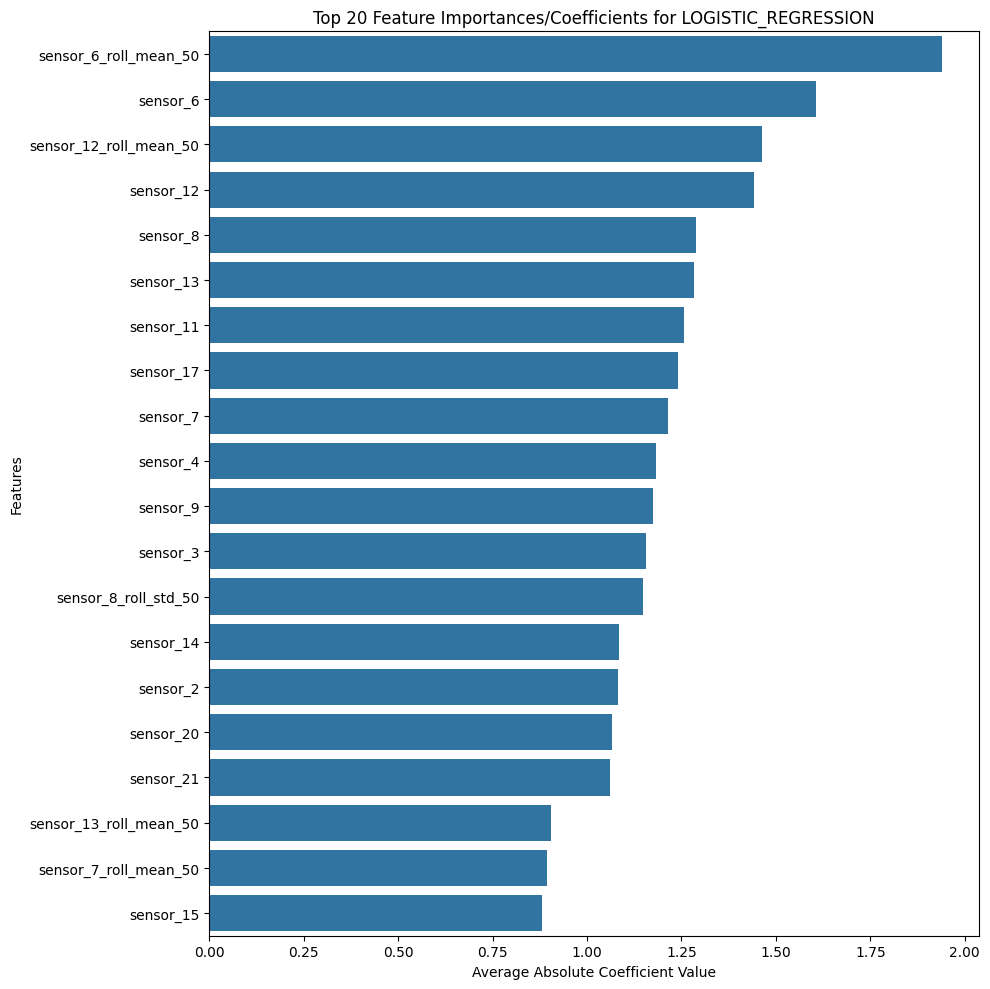


Evaluation for: SVC

Classification Report:
              precision    recall  f1-score   support

     Stage 0       0.99      0.97      0.98      3170
     Stage 1       0.99      0.97      0.98      3256
     Stage 2       0.95      0.99      0.97       857
     Stage 3       0.95      1.00      0.97      1239
     Stage 4       0.97      1.00      0.98       549

    accuracy                           0.98      9071
   macro avg       0.97      0.99      0.98      9071
weighted avg       0.98      0.98      0.98      9071

Overall Accuracy: 0.9793


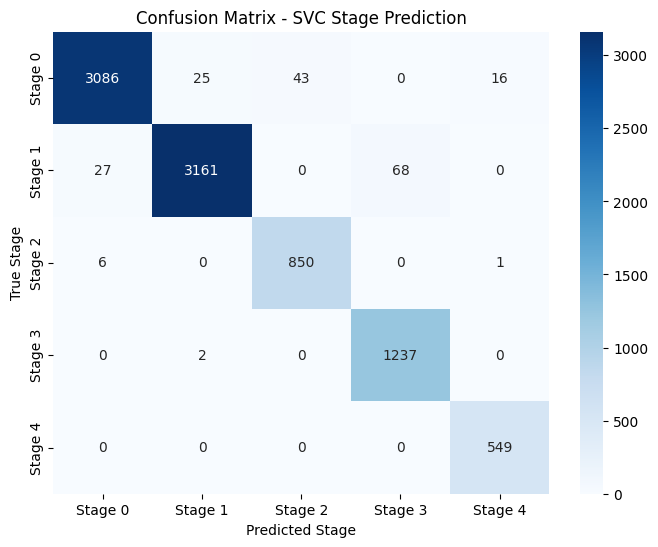


Plotting Feature Importances/Coefficients for SVC...
Feature importances or coefficients are not directly available for model type: SVC

Selected Best Classifier (based on Validation Accuracy): SVC (Accuracy: 0.9793)

Phase 2 Evaluation Complete

Validation Set Predictions (Staging) Head:
       sensor_2  sensor_3  sensor_4  sensor_6  sensor_7  sensor_8  sensor_9  \
35097  1.411884  0.923929  0.114443  0.516939 -0.347204  0.370585 -0.632608   
37594  2.441258  1.727211  1.234422  0.516939 -0.794000  1.000987 -0.093745   
27963 -0.818427 -1.446657 -1.423594 -2.131545 -1.378831 -2.860230 -1.277813   
11267 -1.028115 -0.643376 -0.562706  0.516939 -0.038442 -0.023417 -0.645007   
39416 -0.074990  0.656672 -0.093037 -2.131545  1.581648  0.606986  0.268199   

       sensor_11  sensor_12  sensor_13  ...  prob_stage_1_logistic_regression  \
35097   0.572099  -0.648056   0.292965  ...                      9.990112e-01   
37594   1.803755  -0.736990   1.159094  ...                      2.95133

In [5]:
if 'df_train_clustered' in locals():
     # Target is the primary degradation stage derived from KMeans
     target_stage_col = 'degradation_stage'

     (classifiers, df_val_pred_staging, X_train_class, X_val_class, y_train_class, y_val_class,
      best_classifier_name, classification_accuracies, scaler_numeric_class) = train_and_evaluate_classifiers(
          df_train_clustered, # Pass the dataframe from clustering
          active_sensor_cols,
          op_setting_cols,
          target_col=target_stage_col,
          n_clusters=N_CLUSTERS,
          random_state=RANDOM_STATE,
          include_rolling_features=True, # Use rolling features
          window_size=ROLLING_WINDOW_SIZE
      )

     # df_val_pred_staging now contains features, true stage, predicted stages, and probabilities
     print("\nValidation Set Predictions (Staging) Head:")
     print(df_val_pred_staging.head())
else:
     print("Skipping Phase 2 because Phase 1 did not complete successfully.")

 ## Phase 3: Regression Model (Predicting Time-to-Next-Stage - TTNS)


Calculating Time-to-Next-Stage (TTNS)
Finding first cycle per stage for each engine...
Getting max cycles per engine...
Merging first cycle data back...
Applying TTNS calculation function...
TTNS calculation complete.
Sample TTNS values:
  unit_number  time_in_cycles  degradation_stage  TTNS
0     FD001_1               1                  0  12.0
1     FD001_1               2                  0  11.0
2     FD001_1               3                  0  10.0
3     FD001_1               4                  0   9.0
4     FD001_1               5                  0   8.0
      unit_number  time_in_cycles  degradation_stage  TTNS
45346   FD003_100             148                  3   4.0
45347   FD003_100             149                  3   3.0
45348   FD003_100             150                  3   2.0
45349   FD003_100             151                  3   1.0
45350   FD003_100             152                  3   0.0

Phase 3: Time-to-Next-Stage (TTNS) Prediction Model

Step 1: Defined Regress

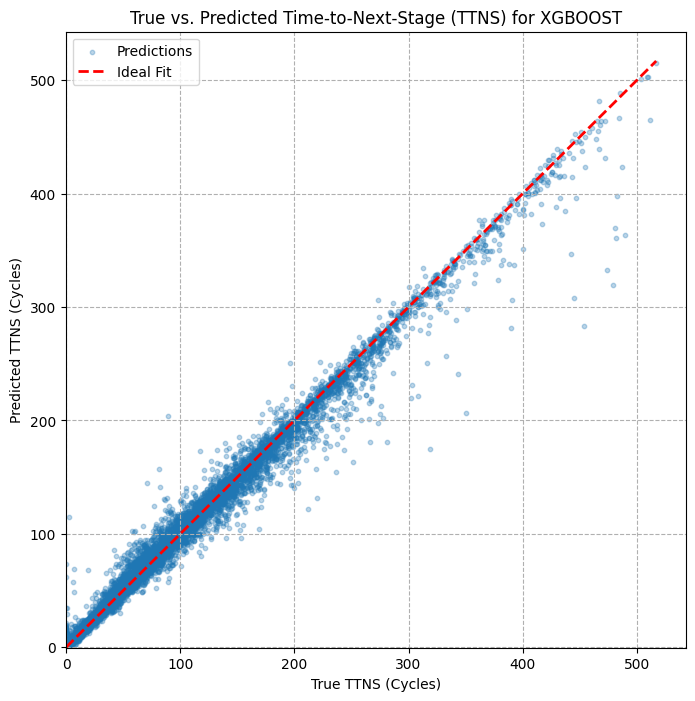


Evaluation for Regressor: HISTGRADIENTBOOSTINGREGRESSOR

Regression Report (Validation Set):
Root Mean Squared Error (RMSE): 21.0926
Mean Absolute Error (MAE):    14.1112
R-squared (R²) Score:         0.9473


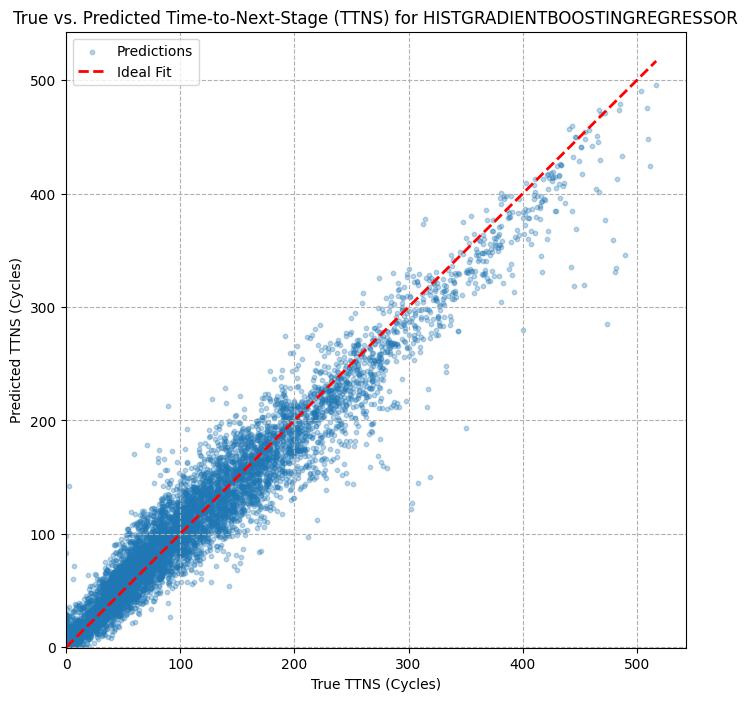


Evaluation for Regressor: NUSVR

Regression Report (Validation Set):
Root Mean Squared Error (RMSE): 46.1812
Mean Absolute Error (MAE):    29.0221
R-squared (R²) Score:         0.7473


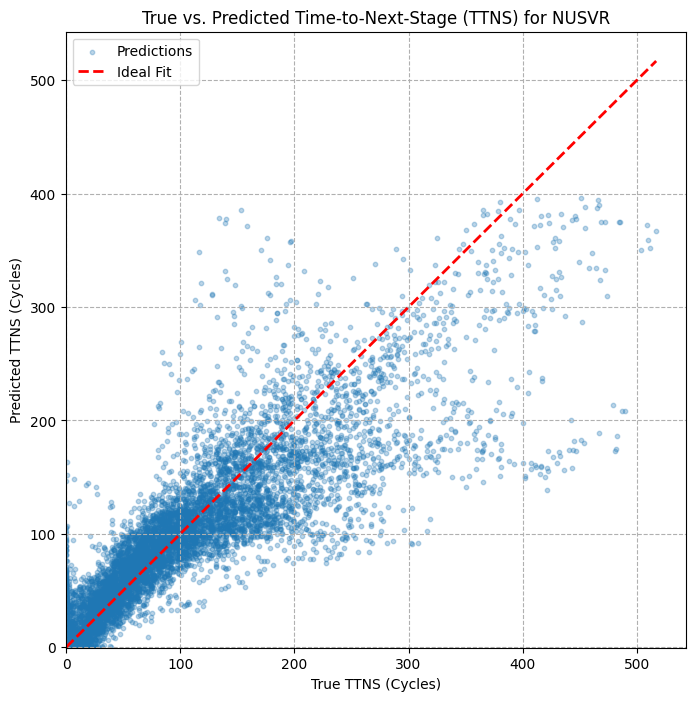


Best performing regressor based on lowest RMSE: XGBOOST (RMSE: 11.3247)

Phase 3 Complete
TTNS calculated and regression models trained/evaluated.

Validation Set Predictions (TTNS) Head:
Merged staging predictions with TTNS results.
       sensor_2  sensor_3  sensor_4  sensor_6  sensor_7  sensor_8  sensor_9  \
35097  1.411884  0.923929  0.114443  0.516939 -0.347204  0.370585 -0.632608   
37594  2.441258  1.727211  1.234422  0.516939 -0.794000  1.000987 -0.093745   
27963 -0.818427 -1.446657 -1.423594 -2.131545 -1.378831 -2.860230 -1.277813   
11267 -1.028115 -0.643376 -0.562706  0.516939 -0.038442 -0.023417 -0.645007   
39416 -0.074990  0.656672 -0.093037 -2.131545  1.581648  0.606986  0.268199   

       sensor_11  sensor_12  sensor_13  ...  predicted_ttns_NuSVR  \
35097   0.572099  -0.648056   0.292965  ...            108.193810   
37594   1.803755  -0.736990   1.159094  ...              6.737728   
27963  -1.172747  -1.181662  -3.329027  ...            257.780366   
11267  -0.1121

In [6]:
if 'df_train_clustered' in locals() and 'best_classifier_name' in locals():
    # Step 3a: Calculate TTNS on the *original* clustered dataframe
    # Use the same target stage column as used for classification
    df_with_ttns = calculate_ttns_for_dataset(df_train_clustered, target_stage_col, N_CLUSTERS)

    # Step 3b: Train and evaluate regressors using the splits from classification phase
    # Pass the dataframe with TTNS, the classification features/targets splits, and the numeric scaler
    (regressors, df_val_pred_ttns, best_regressor_name, regression_results) = train_and_evaluate_regressors(
         df_with_ttns, # Contains the TTNS column aligned by index
         X_train_class, X_val_class, # Features from classification split
         y_train_class, y_val_class, # Stage targets from classification split
         RANDOM_STATE,
         scaler_numeric_class # Scaler fitted on numeric features in classification
     )

    # df_val_pred_ttns now contains validation features, true stage, true TTNS, and predicted TTNS for various models + the best one
    print("\nValidation Set Predictions (TTNS) Head:")
    # Merge the staging predictions into the TTNS results dataframe based on index
    cols_to_merge = ['unit_number', 'time_in_cycles', f'predicted_stage_{best_classifier_name}'] + \
                    [f'prob_stage_{i}_{best_classifier_name}' for i in range(N_CLUSTERS) if f'prob_stage_{i}_{best_classifier_name}' in df_val_pred_staging.columns]

    # Check if staging results df exists and has the necessary columns
    if 'df_val_pred_staging' in locals() and all(c in df_val_pred_staging for c in cols_to_merge):
         df_val_final = df_val_pred_ttns.merge(
             df_val_pred_staging[cols_to_merge],
             left_index=True,
             right_index=True,
             how='left'
         )
         print("Merged staging predictions with TTNS results.")
    else:
         print("Warning: Could not merge staging predictions, df_val_final will only contain TTNS results.")
         df_val_final = df_val_pred_ttns # Use only TTNS results if merge fails

    print(df_val_final.head())
else:
     print("Skipping Phase 3 because Phase 1 or 2 did not complete successfully.")

 ## Phase 4: Risk Score Calculation and Alerting


Phase 4: Risk Score Calculation and Evaluation

Step 1: Calculate Raw Risk Score
Calculating Raw Risk Score using: Probability('prob_stage_4_svc') / (TTNS('predicted_ttns') + epsilon)

Step 2: Normalize Risk Score using Min-Max Scaling...
Raw Risk Score Range: Min=0.0000, Max=999999.9774
Normalized Risk Score Range: Min=0.0000, Max=1.0000

Step 3: Apply Maintenance Alert Threshold
Using Risk Threshold: 0.7

Maintenance Alert Summary (Validation Set):
maintenance_alert
False    8792
True      279
Name: count, dtype: int64

Alerts triggered by True Degradation Stage:
true_stage
4    279
Name: count, dtype: int64

Analysis of Alerts for True Stage 4 (Failure):
Total data points in true_stage 4: 549
Alerts triggered for true_stage 4 points: 279
Percentage of true_stage 4 points that triggered an alert (Recall for Stage 4): 50.82%

Phase 4 Complete
Risk score calculated, normalized, and alerts generated.

Visualizing Risk Score Results

Plotting Normalized Risk Score trends for sample engi

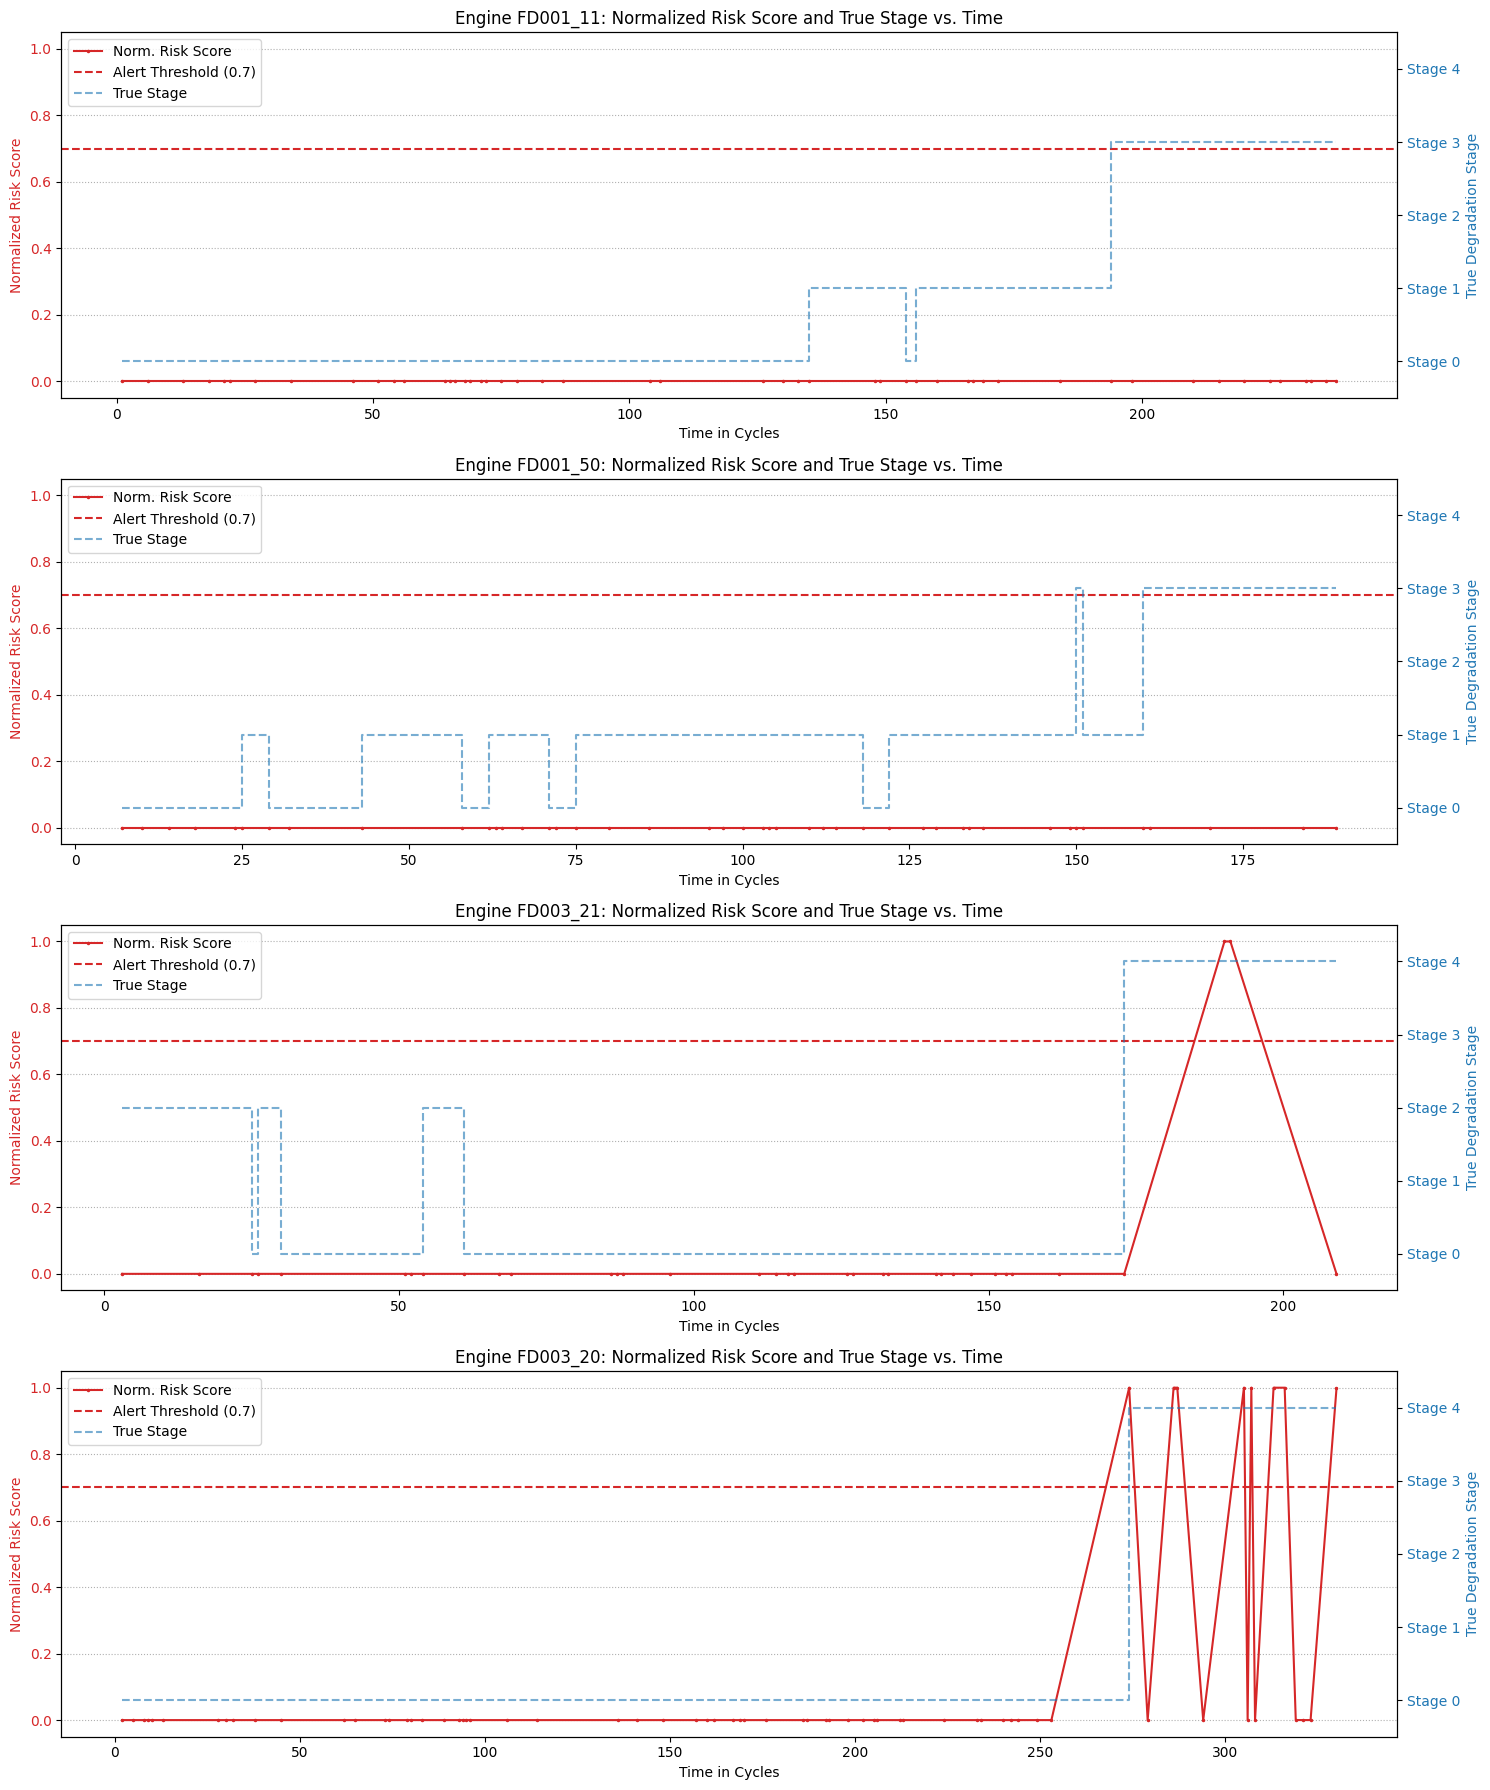


Plotting and Saving Individual Engine Risk Trends
Plots will be saved in directory: 'engine_risk_plots_FD001+FD003'
Found 200 unique engines in the validation set.

Finished plotting. Saved 200 plots to 'engine_risk_plots_FD001+FD003'.


In [7]:
if 'df_val_final' in locals() and best_classifier_name is not None and best_regressor_name is not None:
    # Calculate risk using the best classifier's probabilities and best regressor's TTNS
    df_val_final = calculate_and_evaluate_risk(
        df_val_final,
        best_classifier_name,
        N_CLUSTERS,
        RISK_THRESHOLD
    )

    #Visualize Risk Score
    print("\nVisualizing Risk Score Results")
    # 1. Plot risk trends for the same sample engines used in Phase 1
    plot_risk_trends_sample_engines(
        df_val_final, PLOT_SAMPLE_ENGINES, N_CLUSTERS, RISK_THRESHOLD
    )

    # 2. Plot and save risk trends for ALL engines in the validation set
    plot_and_save_engine_risk_trends(
        df_val_final,
        "engine_risk_plots", # Base directory name
        COMBINED_DATASET_NAME,
        N_CLUSTERS,
        RISK_THRESHOLD
    )
else:
     print("Skipping Phase 4 because prior phases did not complete successfully or required data is missing.")


 ## Pipeline Complete

In [8]:
end_time_total = time.time()
print(f"\nEntire Pipeline Execution Finished")
print(f"Total execution time: {end_time_total - start_time_total:.2f} seconds")

# Final results are in the df_val_final DataFrame (if all phases ran)
if 'df_val_final' in locals():
    print("\nFinal Validation Results DataFrame head:")
    print(df_val_final.head())
    print("\nFinal Validation Results DataFrame info:")
    df_val_final.info()


Entire Pipeline Execution Finished
Total execution time: 408.74 seconds

Final Validation Results DataFrame head:
       sensor_2  sensor_3  sensor_4  sensor_6  sensor_7  sensor_8  sensor_9  \
35097  1.411884  0.923929  0.114443  0.516939 -0.347204  0.370585 -0.632608   
37594  2.441258  1.727211  1.234422  0.516939 -0.794000  1.000987 -0.093745   
27963 -0.818427 -1.446657 -1.423594 -2.131545 -1.378831 -2.860230 -1.277813   
11267 -1.028115 -0.643376 -0.562706  0.516939 -0.038442 -0.023417 -0.645007   
39416 -0.074990  0.656672 -0.093037 -2.131545  1.581648  0.606986  0.268199   

       sensor_11  sensor_12  sensor_13  ...  time_in_cycles  \
35097   0.572099  -0.648056   0.292965  ...              91   
37594   1.803755  -0.736990   1.159094  ...             241   
27963  -1.172747  -1.181662  -3.329027  ...              89   
11267  -0.112154  -0.176317   0.292965  ...              13   
39416  -0.180579   1.381967   0.292965  ...             208   

       predicted_stage_svc  pro